## Extreme Gradient Boosting Machine (XGBM) and Parameter Tunning

**A Gradient Boosting Machine or GBM** combines the predictions from multiple decision trees to generate the final predictions. Keep in mind that all the weak learners in a gradient boosting machine are decision trees.

if we are using the same algorithm, then how is using a hundred decision trees better than using a single decision tree? How do different decision trees capture different signals/information from the data?

Here is the trick – the nodes in every decision tree take a different subset of features for selecting the best split. This means that the individual trees aren’t all the same and hence they are able to capture different signals from the data.

Additionally, each new tree takes into account the errors or mistakes made by the previous trees. So, every successive decision tree is built on the errors of the previous trees. This is how the trees in a gradient boosting machine algorithm are built sequentially.

**Extreme Gradient Boosting or XGBoost** is another popular boosting algorithm. In fact, XGBoost is simply an improvised version of the GBM algorithm! The working procedure of XGBoost is the same as GBM. The trees in XGBoost are built sequentially, trying to correct the errors of the previous trees.

But there are certain features that make XGBoost slightly better than GBM:

1. One of the most important points is that XGBM implements parallel preprocessing (at the node level) which makes it faster than GBM.
2. XGBoost also includes a variety of regularization techniques that reduce overfitting and improve overall performance. You can select the regularization technique by setting the hyperparameters of the XGBoost algorithm.
3. if you are using the XGBM algorithm, you don’t have to worry about imputing missing values in your dataset. The XGBM model can handle the missing values on its own. During the training process, the model learns whether missing values should be in the right or left node.


In [1]:
## Lets see how XGBM improve teh accuracy of model. It works very good If we have very very large datasets.
## We will get very much difference with very less amount of dataset.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as XGB
from sklearn import metrics
import time
%matplotlib inline
from matplotlib.legend_handler import HandlerLine2D

We are using UCI dataset and this is the classic “Adult Data Set”. An older set from 1996, this dataset contains census data on income. Our job is to predict whether a certain individual had an income of greater than 50,000 based on their demographic information.

In [2]:
## I downloaded both files and store at my Github profile.
df_adult = pd.read_csv("C:/E/Github/Data_Files/UCI_Adult/adult.csv")
#df_adult = pd.read_csv("https://raw.githubusercontent.com/atulpatelDS/Data_Files/master/UCI_Adult/adult.csv")

In [3]:
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
df_adult.columns=df_adult.columns.str.replace('-','_')

In [5]:
df_adult.head(1)

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K


In [6]:
print(df_adult.shape)
print(type(df_adult))

(48842, 15)
<class 'pandas.core.frame.DataFrame'>


In [7]:
## Check the intial data type, null value and unique counts
def initial_dataset_check(df):
    """
    A function to make initial check for the dataset including the name, data type, 
    number of null values and number of unique varialbes for each feature.
    """
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    check_df = check_df.sort_values(by='dtype', axis=0, ascending=True)
    
    return check_df

In [8]:
initial_dataset_check(df_adult)

,feature,dtype,num_null,num_unique
0,age,int64,0,74
2,fnlwgt,int64,0,28523
4,educational_num,int64,0,16
10,capital_gain,int64,0,123
11,capital_loss,int64,0,99
12,hours_per_week,int64,0,96
1,workclass,object,0,9
3,education,object,0,16
5,marital_status,object,0,7
6,occupation,object,0,15


In [9]:
print(df_adult.income.unique())

['<=50K' '>50K']


In [10]:
## We can convert the value with 0 and 1
## <=50K == 0 and  >50K ==1
df_adult["income"] = df_adult["income"].map({"<=50K" : 0 , ">50K":1})

In [11]:
income = list(df_adult.income.unique())
income

[0, 1]

In [12]:
df_adult.loc[(df_adult['workclass'] == "?") & (df_adult['occupation'] == "?")]
df_adult.shape

(48842, 15)

In [15]:
### There are 14 columns which have "?" so lets drop these rows 
##df_adult = df_adult[df_adult.workclass != "?"]
df_adult = df_adult[(df_adult != '?').all(axis=1)]
df_adult.shape

(45222, 15)

In [16]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational_num  45222 non-null  int64 
 5   marital_status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital_gain     45222 non-null  int64 
 11  capital_loss     45222 non-null  int64 
 12  hours_per_week   45222 non-null  int64 
 13  native_country   45222 non-null  object
 14  income           45222 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.5+ MB


## Data Analysis

In [17]:
df_adult.groupby(['educational_num', 'education']).size().reset_index(name='Freq')

,educational_num,education,Freq
0,1,Preschool,72
1,2,1st-4th,222
2,3,5th-6th,449
3,4,7th-8th,823
4,5,9th,676
5,6,10th,1223
6,7,11th,1619
7,8,12th,577
8,9,HS-grad,14783
9,10,Some-college,9899


In [18]:
df_adult.groupby(['educational_num', 'education']).size()

educational_num  education   
1                Preschool          72
2                1st-4th           222
3                5th-6th           449
4                7th-8th           823
5                9th               676
6                10th             1223
7                11th             1619
8                12th              577
9                HS-grad         14783
10               Some-college     9899
11               Assoc-voc        1959
12               Assoc-acdm       1507
13               Bachelors        7570
14               Masters          2514
15               Prof-school       785
16               Doctorate         544
dtype: int64

We can see both columns 'educational_num', 'education' are same so One colun is enough, we can delete any column out of two.

In [19]:
df_adult.native_country.value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

In [20]:
df_adult.groupby(["income","native_country"]).size().reset_index(name='Freq')

,income,native_country,Freq
0,0,Cambodia,17
1,0,Canada,103
2,0,China,77
3,0,Columbia,78
4,0,Cuba,99
...,...,...,...
76,1,Thailand,5
77,1,Trinadad&Tobago,2
78,1,United-States,10448
79,1,Vietnam,7


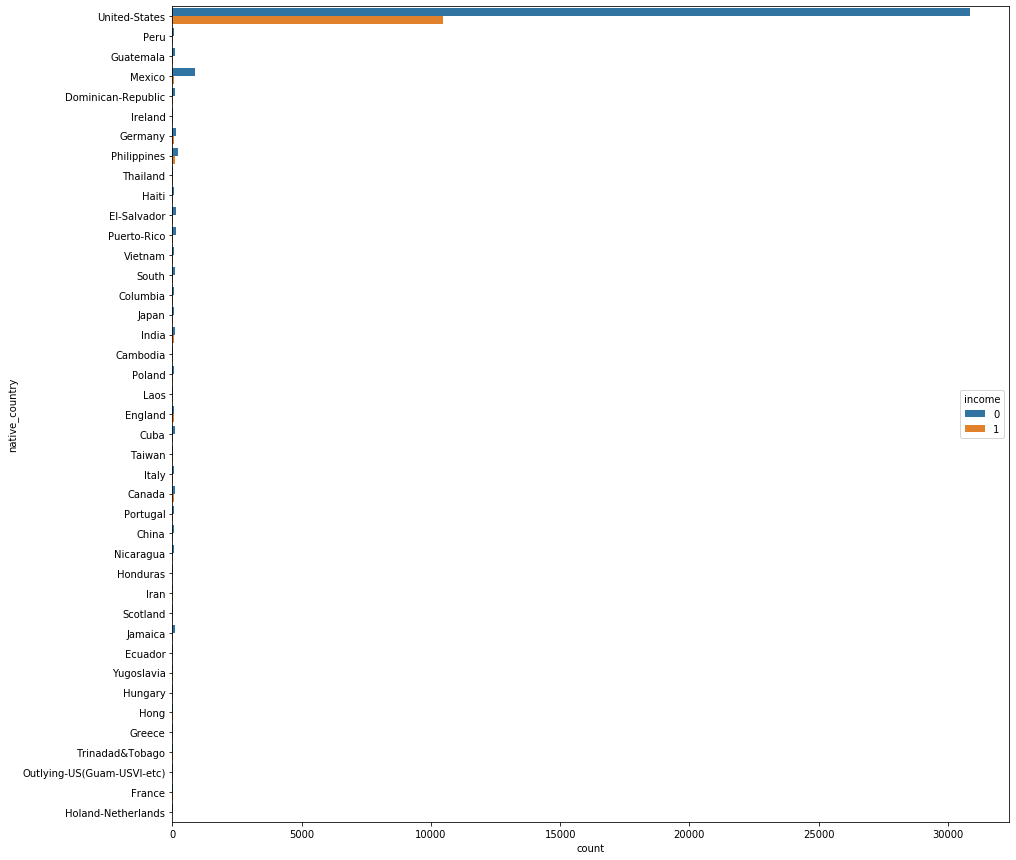

In [21]:
#explore which country do most people belong
sns.countplot(y='native_country',data=df_adult,hue="income")
plt.gcf().set_size_inches(15,15)

Here most people are from the USA,so we can drop this column as it creates unnecessary bias.

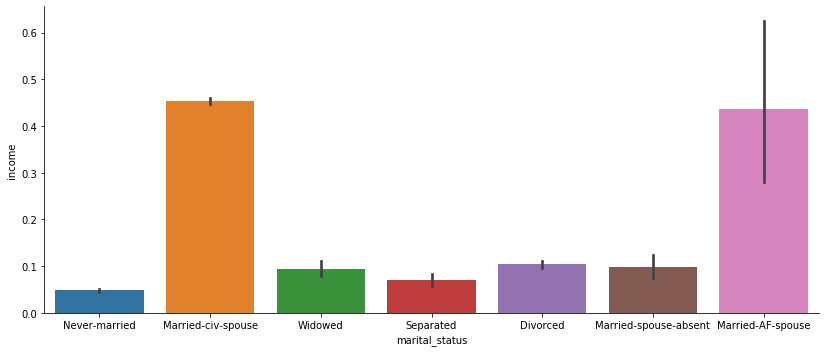

In [22]:
#marital.status vs income
sns.catplot(x='marital_status',y='income',data=df_adult,kind='bar')  ## can use height=5, aspect=12/5
plt.gcf().set_size_inches(14, 5)

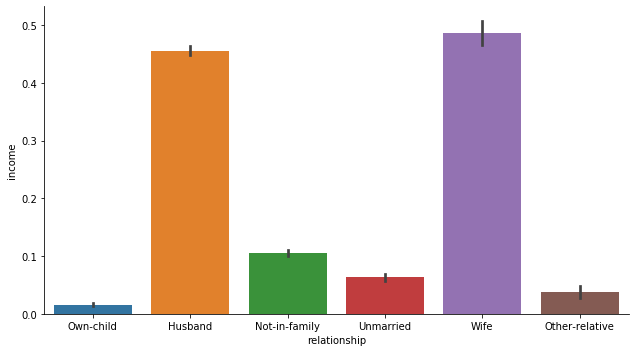

In [23]:
#relationship vs income
sns.catplot(x='relationship',y='income',data=df_adult,kind='bar')
plt.gcf().set_size_inches(10,5)

You can clearly see that "relationship" and "marital.status", look similar i.e. tell us the same thing.
We will look how these are similiar later.

### Feature Engineering

In [24]:
df_adult["marital_status"].unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Separated',
       'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [25]:
#we can reformat marital.status values to single and married
df_adult["marital_status"]=df_adult["marital_status"].map({"Married-civ-spouse":"Married","Divorced":"Single", "Never-married":"Single", "Separated":"Single", 
"Widowed":"Single", "Married-spouse-absent":"Married", "Married-AF-spouse":"Married"})

In [26]:
df_adult["marital_status"].unique()

array(['Single', 'Married'], dtype=object)

In [27]:
##Lets plot the categorical data
cat_cols = df_adult.select_dtypes("object").columns

In [28]:
cat_cols

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'gender', 'native_country'],
      dtype='object')

In [29]:
lb = LabelEncoder()

In [30]:
for col in cat_cols:
    df_adult[col] = lb.fit_transform(df_adult[col])


In [31]:
df_adult.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,2,226802,1,7,1,6,3,2,1,0,0,40,38,0
1,38,2,89814,11,9,0,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,0,10,0,4,1,0,0,40,38,1
3,44,2,160323,15,10,0,6,0,2,1,7688,0,40,38,1
5,34,2,198693,0,6,1,7,1,4,1,0,0,30,38,0


In [32]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              45222 non-null  int64
 1   workclass        45222 non-null  int32
 2   fnlwgt           45222 non-null  int64
 3   education        45222 non-null  int32
 4   educational_num  45222 non-null  int64
 5   marital_status   45222 non-null  int32
 6   occupation       45222 non-null  int32
 7   relationship     45222 non-null  int32
 8   race             45222 non-null  int32
 9   gender           45222 non-null  int32
 10  capital_gain     45222 non-null  int64
 11  capital_loss     45222 non-null  int64
 12  hours_per_week   45222 non-null  int64
 13  native_country   45222 non-null  int32
 14  income           45222 non-null  int64
dtypes: int32(8), int64(7)
memory usage: 5.4 MB


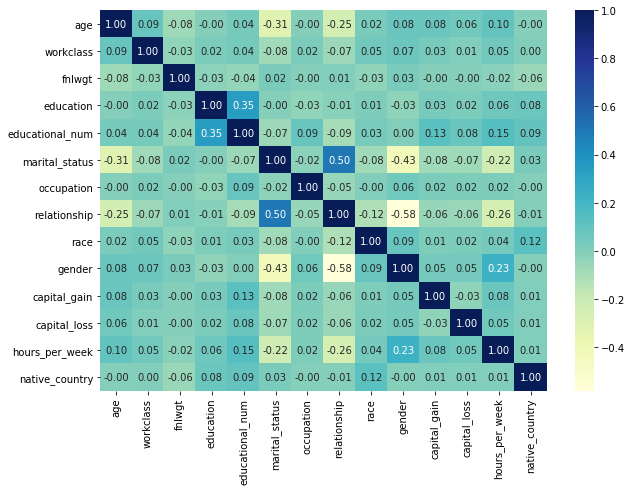

In [33]:
## Lest check the co-relations
plt.figure(figsize=(10,7))
sns.heatmap(df_adult.iloc[:,:-1].corr(),annot=True,fmt='.2f',cmap = "YlGnBu") ## Only Independant Variables

As we can see from the heatmap "education" and "education.num" are highly correlated and also we can see earlier both are highly corelated, same can be said about the "marital.status" and "relationship" ,thus,we can drop "relationship" and "education".


In [34]:
df_adult = df_adult.drop(['relationship','education'],axis=1)

Also we drop the "native.country" as more are from single country(USA) which can cause bias.

In [35]:
df_adult = df_adult.drop("native_country",axis=1)

In [36]:
df_adult.head()

,age,workclass,fnlwgt,educational_num,marital_status,occupation,race,gender,capital_gain,capital_loss,hours_per_week,income
0,25,2,226802,7,1,6,2,1,0,0,40,0
1,38,2,89814,9,0,4,4,1,0,0,50,0
2,28,1,336951,12,0,10,4,1,0,0,40,1
3,44,2,160323,10,0,6,2,1,7688,0,40,1
5,34,2,198693,6,1,7,4,1,0,0,30,0


In [37]:
df_adult.describe()

,age,workclass,fnlwgt,educational_num,marital_status,occupation,race,gender,capital_gain,capital_loss,hours_per_week,income
count,45222.000000,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,2.204502,1.897347e+05,10.118460,0.521494,5.969572,3.680288,0.675048,1101.430344,88.595418,40.938017,0.247844
std,13.217870,0.958122,1.056392e+05,2.552881,0.499543,4.026400,0.832353,0.468362,7506.430084,404.956092,12.007508,0.431766
min,17.000000,0.000000,1.349200e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,2.000000,1.173882e+05,9.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,2.000000,1.783160e+05,10.000000,1.000000,6.000000,4.000000,1.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.000000,2.379260e+05,13.000000,1.000000,9.000000,4.000000,1.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,6.000000,1.490400e+06,16.000000,1.000000,13.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,1.000000


In [38]:
df_adult.shape

(45222, 12)

In [39]:
## Scalling is not required for Boosting Algorithm

In [40]:
X = df_adult.iloc[:,0:-1]
y = df_adult.income

In [41]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(45222, 11)
(45222,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [42]:
## Now split the test train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.333,random_state = 42)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))

(30163, 11)
(30163,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [44]:
print(X_test.shape)
print(y_test.shape)
print(type(X_test))
print(type(y_test))

(15059, 11)
(15059,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [45]:
X_cols = [x for x in X_train.columns]
X_cols

['age',
 'workclass',
 'fnlwgt',
 'educational_num',
 'marital_status',
 'occupation',
 'race',
 'gender',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [46]:
### To understand the ROC and AUC please refer below
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

est = LogisticRegression(class_weight='auto')
X = np.random.rand(10, 2)
y = np.random.randint(2, size=10)
est.fit(X, y)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, est.predict(X))
print(auc(false_positive_rate, true_positive_rate))
print(roc_auc_score(y, est.predict(X)))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, est.predict_proba(X)[:,1])
print(auc(false_positive_rate, true_positive_rate))
print(roc_auc_score(y, est.predict_proba(X)[:,1]))

0.6
0.6
0.72
0.72


In [47]:
def evaluate_model(alg,X_train,y_train,X_test,y_test, X_cols, cv_folds=5):
    #Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    #y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    y_test_pred = alg.predict(X_test)
    #y_test_predprob = alg.predict_proba(X_test)[:,1]
    
    # Print the ROC_AUC on training dataset
    false_positive_rate_train, true_positive_rate_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
    roc_auc_score_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_train = metrics.auc(false_positive_rate_train, true_positive_rate_train)
    
    

    # Print the ROC_AUC on test dataset
    false_positive_rate_test, true_positive_rate_test, thresholds_test = metrics.roc_curve(y_test, y_test_pred)
    roc_auc_score_test = metrics.roc_auc_score(y_test, y_test_pred)
    auc_test = metrics.auc(false_positive_rate_test, true_positive_rate_test)
      
        
    #Print model report:
    print("\nBase Model Report with Default Parameters")
    print("Accuracy (Train) : %f" % metrics.accuracy_score(y_train, y_train_pred))
    print("AUC (Train): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_train)
    print("F1 Score (Train): %f" % metrics.f1_score(y_train, y_train_pred))
    print("Classification Report (Train): {}\n".format(metrics.classification_report(y_train,y_train_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Accuracy (Test) : %f" % metrics.accuracy_score(y_test, y_test_pred))
    print("AUC (Test): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_test)
    print("F1 Score (Test): %f" % metrics.f1_score(y_test,y_test_pred))
    print("Classification Report (Test): {}\n".format(metrics.classification_report(y_test,y_test_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
            
    #Print Feature Importance:
    feat_imp = pd.Series(alg.feature_importances_, X_cols).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

**We will use AUC (Area Under Curve) and F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC ,ROC_AUC_SCORE and F1 score is a good way for evaluation for this type of problems**

In [48]:
def modelfit_GS(alg,X_train,y_train,X_test,y_test, X_cols):
    #Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    #y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    y_test_pred = alg.predict(X_test)
    #y_test_predprob = alg.predict_proba(X_test)[:,1]
    
    # Print the ROC_AUC on training dataset
    false_positive_rate_train, true_positive_rate_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
    roc_auc_score_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_train = metrics.auc(false_positive_rate_train, true_positive_rate_train)
    
    

    # Print the ROC_AUC on test dataset
    false_positive_rate_test, true_positive_rate_test, thresholds_test = metrics.roc_curve(y_test, y_test_pred)
    roc_auc_score_test = metrics.roc_auc_score(y_test, y_test_pred)
    auc_test = metrics.auc(false_positive_rate_test, true_positive_rate_test)
      
        
    #Print model report:
    print("\nBase Model Report with Default Parameters")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, y_train_pred))
    print("AUC (Train): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_train)
    print("F1 Score (Train): %f" % metrics.f1_score(y_train, y_train_pred))
    print("Classification Report (Train): {}\n".format(metrics.classification_report(y_train,y_train_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Accuracy (Test) : %f" % metrics.accuracy_score(y_test, y_test_pred))
    print("AUC (Test): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_test)
    print("F1 Score (Test): %f" % metrics.f1_score(y_test,y_test_pred))
    print("Classification Report (Test): {}\n".format(metrics.classification_report(y_test,y_test_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Best Score using GridSearch : {}\n".format(alg.best_score_))
    print("Best Parameter using GridSearch : {}\n".format(alg.best_params_))   
    ## Plot the Grapg with Mean test score 
    cv_results = pd.DataFrame(alg.cv_results_)
    plt.figure(figsize=(15,5))
    palette = sns.color_palette("Set1", n_colors=6, desat=.5)
    sns.lineplot(data=cv_results,x=cv_results.iloc[:,4],
                 y=cv_results.iloc[:,-3]
                 #,hue=cv_results["param_learning_rate"]
                 ,palette=palette
                 #,err_style="bars", ci=58,lw=1,err_kws={'capsize':0.5}
                 #,size=cv_results["param_learning_rate"]
                 #,sizes=(.25, 2.5)
                )
    

### XGBClassifier

#### Base Model

In [49]:
xgb = XGBClassifier(random_state=10,n_jobs=8)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Base Model Report with Default Parameters
Accuracy (Train) : 0.862481
AUC (Train): 0.774953
ROC_AUC_Score (Train): 0.774953
F1 Score (Train): 0.684467
Classification Report (Train):               precision    recall  f1-score   support

           0       0.88      0.95      0.91     22680
           1       0.79      0.60      0.68      7483

    accuracy                           0.86     30163
   macro avg       0.84      0.77      0.80     30163
weighted avg       0.86      0.86      0.86     30163


Accuracy (Test) : 0.864134
AUC (Test): 0.774953
ROC_AUC_Score (Train): 0.777094
F1 Score (Test): 0.687729
Classification Report (Test):               precision    recall  f1-score   support

           0       0.88      0.95      0.91     11334
           1       0.80      0.60      0.69      3725

    accuracy                           0.86     15059
   macro avg       0.84      0.78      0.80     15059
weighted avg       0.86      0.86      0.86     15059


Time taken by Model:  0.1

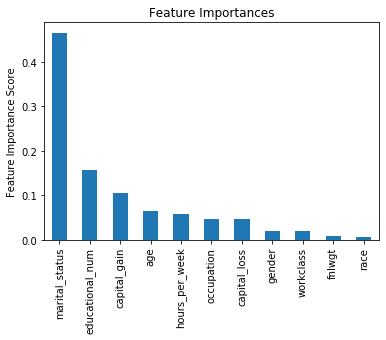

In [50]:
## Evaluate the base model
starttime = time.time()
evaluate_model(xgb,X_train,y_train,X_test,y_test, X_cols, cv_folds=5)
endtime = time.time()
print("Time taken by Model: ",endtime - starttime)

#### Parameter Tunning of XGB with SkLearn and Gridsearch

In [51]:
### Max_depth tunning and setting all the remaining parameters default
param_value1 = range(1,15)
param_name1 = "max_depth"
param_test1 =  {'max_depth':range(1,15)}
gs_xgb1 = GridSearchCV(estimator = XGBClassifier(random_state=10),param_grid = param_test1,
                       scoring='roc_auc',cv=5,n_jobs=8)
## for scoring
## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [52]:
%time gs_xgb1.fit(X_train,y_train)

Wall time: 37.8 s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=10, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=8, param_grid={'max_depth': range(1, 15)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)


Base Model Report with Default Parameters
Accuracy (Train) : 0.8796
AUC (Train): 0.809633
ROC_AUC_Score (Train): 0.809633
F1 Score (Train): 0.734362
Classification Report (Train):               precision    recall  f1-score   support

           0       0.90      0.95      0.92     22680
           1       0.81      0.67      0.73      7483

    accuracy                           0.88     30163
   macro avg       0.85      0.81      0.83     30163
weighted avg       0.88      0.88      0.88     30163


Accuracy (Test) : 0.871041
AUC (Test): 0.809633
ROC_AUC_Score (Train): 0.796641
F1 Score (Test): 0.713569
Classification Report (Test):               precision    recall  f1-score   support

           0       0.89      0.94      0.92     11334
           1       0.79      0.65      0.71      3725

    accuracy                           0.87     15059
   macro avg       0.84      0.80      0.82     15059
weighted avg       0.87      0.87      0.87     15059


Best Score using GridSearch

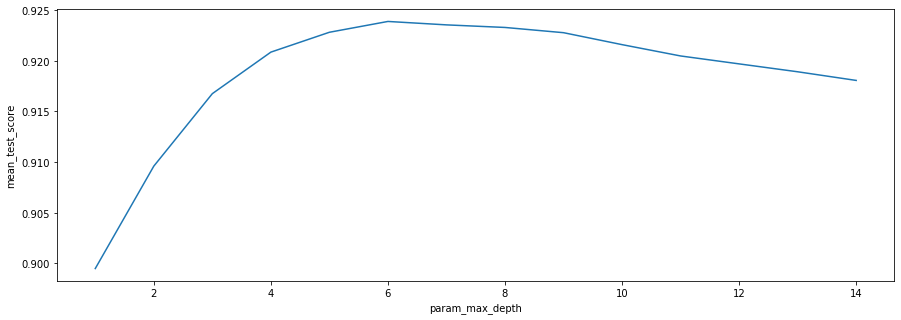

In [53]:
%time modelfit_GS(gs_xgb1,X_train,y_train,X_test,y_test, X_cols)

In [54]:
### min_child_weight tunning and taking max_depth = 6 and setting all the remaining parameters default
param_value2 = range(1,5)
param_name2 = "min_child_weight"
param_test2 =  {'min_child_weight':range(1,5)}
gs_xgb2 = GridSearchCV(estimator = XGBClassifier(random_state=10,max_depth=6),param_grid = param_test2,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [55]:
%time gs_xgb2.fit(X_train,y_train)

Wall time: 8.67 s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=10, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=8,
             param_grid={'min_child_weight': range(1, 5)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)


Base Model Report with Default Parameters
Accuracy (Train) : 0.8796
AUC (Train): 0.809633
ROC_AUC_Score (Train): 0.809633
F1 Score (Train): 0.734362
Classification Report (Train):               precision    recall  f1-score   support

           0       0.90      0.95      0.92     22680
           1       0.81      0.67      0.73      7483

    accuracy                           0.88     30163
   macro avg       0.85      0.81      0.83     30163
weighted avg       0.88      0.88      0.88     30163


Accuracy (Test) : 0.871041
AUC (Test): 0.809633
ROC_AUC_Score (Train): 0.796641
F1 Score (Test): 0.713569
Classification Report (Test):               precision    recall  f1-score   support

           0       0.89      0.94      0.92     11334
           1       0.79      0.65      0.71      3725

    accuracy                           0.87     15059
   macro avg       0.84      0.80      0.82     15059
weighted avg       0.87      0.87      0.87     15059


Best Score using GridSearch

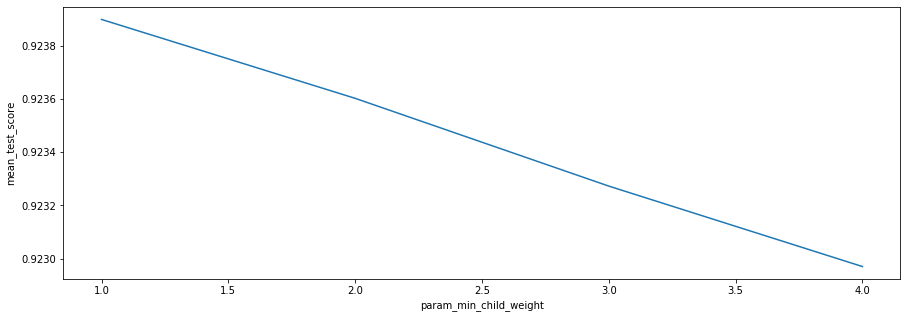

In [56]:
%time modelfit_GS(gs_xgb2,X_train,y_train,X_test,y_test, X_cols)

In [57]:
param_value3 = range(50,1050,100)
param_name3 = "n_estimators"
param_test3 =  {'n_estimators':range(50,1050,100)}
gs_xgb3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,random_state=10,max_depth=6,min_child_weight=1),param_grid = param_test3,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [58]:
%time gs_xgb3.fit(X_train,y_train)

Wall time: 1min 49s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=10, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=8,
             param_grid={'n_estimators': range(50, 1050, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose


Base Model Report with Default Parameters
Accuracy (Train) : 0.8856
AUC (Train): 0.818929
ROC_AUC_Score (Train): 0.818929
F1 Score (Train): 0.748598
Classification Report (Train):               precision    recall  f1-score   support

           0       0.90      0.95      0.93     22680
           1       0.82      0.69      0.75      7483

    accuracy                           0.89     30163
   macro avg       0.86      0.82      0.84     30163
weighted avg       0.88      0.89      0.88     30163


Accuracy (Test) : 0.871373
AUC (Test): 0.818929
ROC_AUC_Score (Train): 0.799024
F1 Score (Test): 0.716107
Classification Report (Test):               precision    recall  f1-score   support

           0       0.89      0.94      0.92     11334
           1       0.79      0.66      0.72      3725

    accuracy                           0.87     15059
   macro avg       0.84      0.80      0.82     15059
weighted avg       0.87      0.87      0.87     15059


Best Score using GridSearch

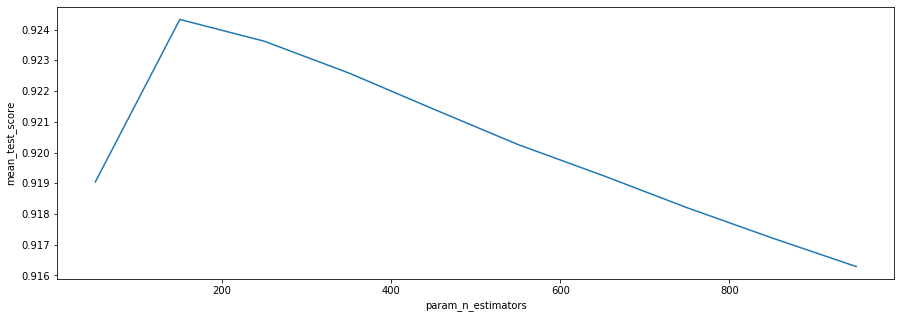

In [59]:
%time modelfit_GS(gs_xgb3,X_train,y_train,X_test,y_test, X_cols)

In [60]:
param_value4 = [0.1,0.02,0.03,0.04,0.05,0.06,0.001]
param_name4 = "learning_rate"
param_test4 =  {'learning_rate':[0.1,0.02,0.03,0.04,0.05,0.06,0.001]}
gs_xgb4 = GridSearchCV(estimator = XGBClassifier(random_state=10,max_depth=6,min_child_weight=1,n_estimators =150),param_grid = param_test4,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [61]:
%time gs_xgb4.fit(X_train,y_train)

Wall time: 25.5 s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=10, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=8,
             param_grid={'learning_rate': [0.1, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.001]},
             pre_dispatch='2*n_jobs', refit=True,


Base Model Report with Default Parameters
Accuracy (Train) : 0.8856
AUC (Train): 0.818929
ROC_AUC_Score (Train): 0.818929
F1 Score (Train): 0.748598
Classification Report (Train):               precision    recall  f1-score   support

           0       0.90      0.95      0.93     22680
           1       0.82      0.69      0.75      7483

    accuracy                           0.89     30163
   macro avg       0.86      0.82      0.84     30163
weighted avg       0.88      0.89      0.88     30163


Accuracy (Test) : 0.871373
AUC (Test): 0.818929
ROC_AUC_Score (Train): 0.799024
F1 Score (Test): 0.716107
Classification Report (Test):               precision    recall  f1-score   support

           0       0.89      0.94      0.92     11334
           1       0.79      0.66      0.72      3725

    accuracy                           0.87     15059
   macro avg       0.84      0.80      0.82     15059
weighted avg       0.87      0.87      0.87     15059


Best Score using GridSearch

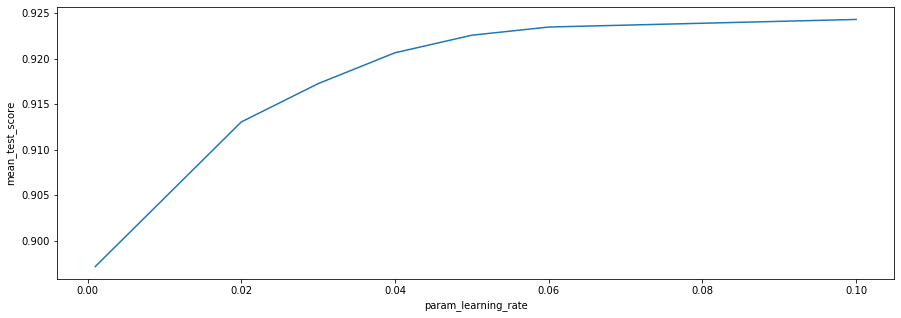

In [62]:
%time modelfit_GS(gs_xgb4,X_train,y_train,X_test,y_test, X_cols)

**Now Apply these best parameters in our base model and make final model using sklearn XGB**

In [63]:
xgb_final = XGBClassifier(n_jobs=8,random_state=10,max_depth=6,
                    min_child_weight=1,n_estimators = 150,learning_rate=0.1,reg_alpha=0)
%time xgb_final.fit(X_train,y_train)

Wall time: 1.06 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Base Model Report with Default Parameters
Accuracy (Train) : 0.885588
AUC (Train): 0.818929
ROC_AUC_Score (Train): 0.818929
F1 Score (Train): 0.748598
Classification Report (Train):               precision    recall  f1-score   support

           0       0.90      0.95      0.93     22680
           1       0.82      0.69      0.75      7483

    accuracy                           0.89     30163
   macro avg       0.86      0.82      0.84     30163
weighted avg       0.88      0.89      0.88     30163


Accuracy (Test) : 0.871373
AUC (Test): 0.818929
ROC_AUC_Score (Train): 0.799024
F1 Score (Test): 0.716107
Classification Report (Test):               precision    recall  f1-score   support

           0       0.89      0.94      0.92     11334
           1       0.79      0.66      0.72      3725

    accuracy                           0.87     15059
   macro avg       0.84      0.80      0.82     15059
weighted avg       0.87      0.87      0.87     15059


Time taken by Model:  0.2

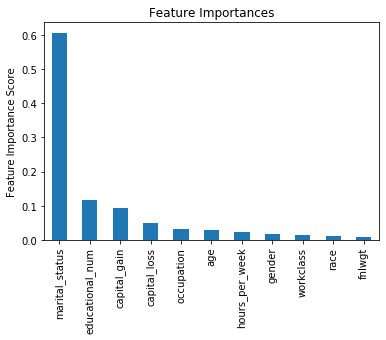

In [64]:
## Evaluate the base model
starttime = time.time()
evaluate_model(xgb_final,X_train,y_train,X_test,y_test, X_cols, cv_folds=5)
endtime = time.time()
print("Time taken by Model: ",endtime - starttime)

**XGBoost's built-in cv which allows early stopping to prevent overfitting**

To increase the performance of XGBoost's speed through many iterations of the training set, and since we are using only XGBoost's API and not sklearn's anymore, we can create a DMatrix. This sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient. This is especially helpful when we have a very large number of training examples. To create a DMatrix:

In [65]:
## DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
xgb_dmat = XGB.DMatrix(X_train,y_train)

Now let's specify our parameters (with slightly different syntax in some places for the XGBoost native API) and set our stopping criteria.

In [66]:
xgb_param = {'eta': 0.07, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':6, 'min_child_weight':1} 

In [67]:
%time xgb_cv = XGB.cv(params=xgb_param,dtrain=xgb_dmat,num_boost_round=8000,nfold=5,metrics="error",early_stopping_rounds=50)
# lets take early stopping that minimizes error,
# We need to make sure that we enter metrics inside a list or we may encounter issues!

Wall time: 8.54 s


We can look at our CV results to see how accurate we were with these settings. The output is automatically saved into a pandas dataframe for us.

In [68]:
xgb_cv.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
189,0.113483,0.001196,0.131784,0.002681
190,0.113309,0.001204,0.131718,0.002705
191,0.113251,0.001205,0.131850,0.002936
192,0.113127,0.001224,0.131552,0.002936
193,0.112903,0.001085,0.131453,0.002931


Our CV test error at this number of iterations is 13.14%, or 87.14% accuracy.

Now that we have our best settings, let's create this as an XGBoost object model that we can reference later.

In [69]:
xgb_param = {'eta': 0.06, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':6, 'min_child_weight':1} 

XGB_final = XGB.train(xgb_param, xgb_dmat, num_boost_round = 193)  ### our cv was stopet at 155

### Plotting feature importance

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

<Figure size 432x288 with 0 Axes>

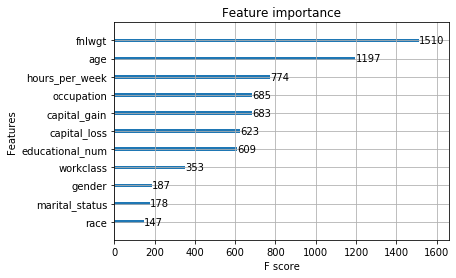

In [70]:
plt.figure(figsize=(6,4))
XGB.plot_importance(XGB_final)
## F score is a metric that simply sums up how many times each feature is split on

This will tell us which features were most important in the series of trees. The **'fnlwgt'** feature seems to have the most importance filing.


####  Lets compute the performance on test data

The model has now been tuned using cross-validation grid search through the sklearn API and early stopping through the built-in XGBoost API. Now, we can see how it finally performs on the test set. Does it match our CV performance? First, create another DMatrix (this time for the test data).

In [71]:
xgb_dmat_test = XGB.DMatrix(X_test)

In [72]:
## lets calculate y_pred using DMAT
y_pred_xgb = XGB_final.predict(xgb_dmat_test)
y_pred_xgb

array([0.00897498, 0.13539638, 0.5528122 , ..., 0.43945658, 0.00323098,
       0.99821186], dtype=float32)

**You can see that the predict function for XGBoost outputs probabilities** by default and not actual class labels. To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.

In [73]:
y_pred_xgb[y_pred_xgb>0.5] = 1
y_pred_xgb[y_pred_xgb<=0.5] = 0

In [74]:
y_pred_xgb

array([0., 0., 1., ..., 0., 0., 1.], dtype=float32)

In [75]:
acc_score = metrics.accuracy_score(y_test,y_pred_xgb)
print("XGB Accuracy Score on test data : {}".format(acc_score))

XGB Accuracy Score on test data : 0.8720366558204397


In [76]:
F1Score = metrics.f1_score(y_test,y_pred_xgb)
print("XGB F1 Score on test data : {}".format(F1Score))

XGB F1 Score on test data : 0.716242085112649


In [77]:
ROC_AUC_Score = metrics.roc_auc_score(y_test,y_pred_xgb)
print("XGB ROC_AUC Score on test data : {}".format(ROC_AUC_Score))

XGB ROC_AUC Score on test data : 0.7984740100167815


In [79]:
print(metrics.classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     11334
           1       0.79      0.65      0.72      3725

    accuracy                           0.87     15059
   macro avg       0.84      0.80      0.82     15059
weighted avg       0.87      0.87      0.87     15059



In [81]:
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22ad83d8648>)

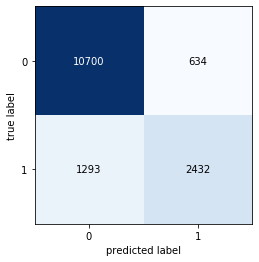

In [82]:
plot_confusion_matrix(metrics.confusion_matrix(y_test,y_pred_xgb))